# Impoerting required libraries

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters
import seaborn as sns


%matplotlib inline
%config InlineBackend.figure_format='retina'

# Get the Dataset

Its import to note that the dataset has been pre-processed, with missing values replaced with mean per column accordingly. Therefore the imported datset is ready for use

In [2]:
df = pd.read_csv('AnomalyClean.csv')

In [3]:
df.head()

,Interval,DynamicViscosityAvg,DynamicViscosityMin,DynamicViscosityMax,DielectricConstAvg,DielectricConstMin,DielectricConstMax,DensityAvg,DensityMin,DensityMax,TemperatureAvg,TemperatureMin,TemperatureMax
0,2021/11/01 06:00,128.41665,16.709091,240.336364,118.060069,26.831818,219.045455,129.307523,15.863636,241.822727,44.014125,41.890411,63.643836
1,2021/11/01 10:00,128.41665,16.709091,240.336364,118.060069,26.831818,219.045455,129.307523,15.863636,241.822727,44.014125,41.890411,63.643836
2,2021/11/01 14:00,128.41665,16.709091,240.336364,118.060069,26.831818,219.045455,129.307523,15.863636,241.822727,44.014125,41.890411,63.643836
3,2021/11/01 18:00,128.41665,16.709091,240.336364,118.060069,26.831818,219.045455,129.307523,15.863636,241.822727,44.014125,41.890411,63.643836
4,2021/11/01 22:00,128.41665,16.709091,240.336364,118.060069,26.831818,219.045455,129.307523,15.863636,241.822727,44.014125,41.890411,63.643836


In [4]:
df.shape

(771, 13)

Covert Intervals into dateTime stamps

In [5]:
df['Interval'] = pd.to_datetime(df['Interval'])
df.dtypes

Interval               datetime64[ns]
DynamicViscosityAvg           float64
DynamicViscosityMin           float64
DynamicViscosityMax           float64
DielectricConstAvg            float64
DielectricConstMin            float64
DielectricConstMax            float64
DensityAvg                    float64
DensityMin                    float64
DensityMax                    float64
TemperatureAvg                float64
TemperatureMin                float64
TemperatureMax                float64
dtype: object

# Isolate Temperature Data and Visualize

In [1]:
df_Temp = df[['Interval', 'TemperatureAvg']]
df_Temp.head(3)

NameError: ignored

In [2]:
plt.figure(1, figsize = (10, 6))
plt.plot(df['Interval'], df['TemperatureAvg'])
plt.xlabel('Sample date')
plt.ylabel('Average Temperature')

NameError: ignored

# Splitting the Dataset

We set training data to be 70% of the entire dataframe, consequently, the test dataset will be 30%.

In [16]:
train_size = int(len(df_Temp) * 0.70)
test_size = int(len(df_Temp) * (1-0.70))

train, test = df_Temp.iloc[0:train_size], df_Temp.iloc[train_size:len(df_Temp)]
print(train.shape, test.shape)

(539, 2) (232, 2)


# Scaling the training and test data

In [17]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler = scaler.fit(train[['TemperatureAvg']])

train['TemperatureAvg'] = scaler.transform(train[['TemperatureAvg']])
test['TemperatureAvg'] = scaler.transform(test[['TemperatureAvg']])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [18]:
train.head()

,Interval,TemperatureAvg
0,2021-11-01 06:00:00,0.006839
1,2021-11-01 10:00:00,0.006839
2,2021-11-01 14:00:00,0.006839
3,2021-11-01 18:00:00,0.006839
4,2021-11-01 22:00:00,0.006839


In [19]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)        
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [21]:
TIME_STEPS = 30

# reshape to [samples, time_steps, n_features]

X_train, y_train = create_dataset(train[['TemperatureAvg']], train.TemperatureAvg, TIME_STEPS)
X_test, y_test = create_dataset(test[['TemperatureAvg']], test.TemperatureAvg, TIME_STEPS)

print(X_train.shape)

(509, 30, 1)


In [9]:
!pip install gdown
!pip install tensorflow-gpu

     |████████████████████████████████| 489.6 MB 22 kB/s 


# LSTM Autoencoders

In [51]:
model = keras.Sequential()
model.add(keras.layers.LSTM(
    units=64, 
    input_shape=(X_train.shape[1], X_train.shape[2])
))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.RepeatVector(n=X_train.shape[1]))
model.add(keras.layers.LSTM(units=64, return_sequences=True))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.TimeDistributed(keras.layers.Dense(units=X_train.shape[2])))
model.compile(loss='mae', optimizer='adam')

In [52]:
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=200,
    validation_split=0.9,
    shuffle=False
)

Epoch 1/10
1/1 [==============================] - 5s 5s/step - loss: 0.1740 - val_loss: 0.2505
Epoch 2/10
1/1 [==============================] - 0s 166ms/step - loss: 0.1719 - val_loss: 0.2490
Epoch 3/10
1/1 [==============================] - 0s 165ms/step - loss: 0.1708 - val_loss: 0.2451
Epoch 4/10
1/1 [==============================] - 0s 165ms/step - loss: 0.1673 - val_loss: 0.2465
Epoch 5/10
1/1 [==============================] - 0s 185ms/step - loss: 0.1700 - val_loss: 0.2475
Epoch 6/10
1/1 [==============================] - 0s 160ms/step - loss: 0.1700 - val_loss: 0.2461
Epoch 7/10
1/1 [==============================] - 0s 159ms/step - loss: 0.1676 - val_loss: 0.2448
Epoch 8/10
1/1 [==============================] - 0s 164ms/step - loss: 0.1669 - val_loss: 0.2452
Epoch 9/10
1/1 [==============================] - 0s 161ms/step - loss: 0.1675 - val_loss: 0.2452
Epoch 10/10
1/1 [==============================] - 0s 163ms/step - loss: 0.1671 - val_loss: 0.2443


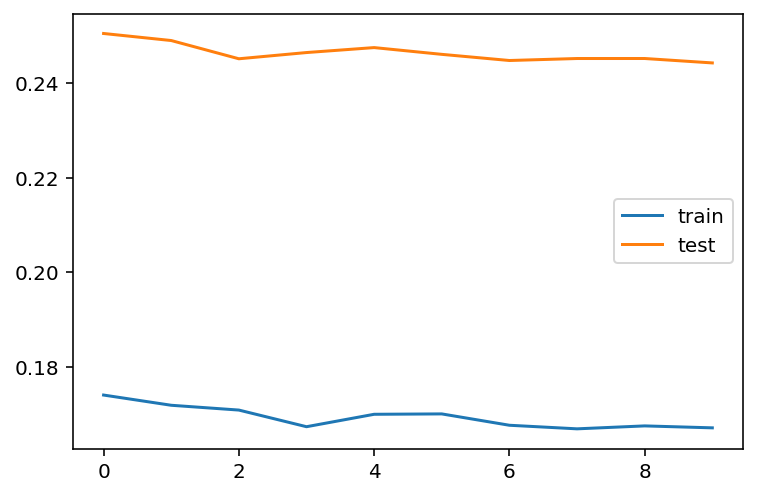

In [53]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();

In [54]:
X_train_pred = model.predict(X_train)

train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


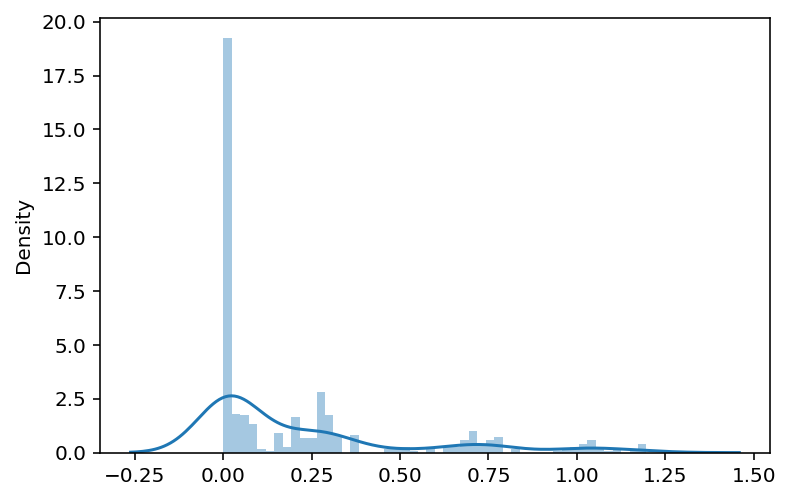

In [55]:
sns.distplot(train_mae_loss, bins=50, kde=True);

In [56]:
X_test_pred = model.predict(X_test)

test_mae_loss = np.mean(np.abs(X_test_pred - X_test), axis=1)

In [57]:
THRESHOLD = 0.65

test_score_df = pd.DataFrame(index=test[TIME_STEPS:].index)
test_score_df['loss'] = test_mae_loss
test_score_df['threshold'] = THRESHOLD
test_score_df['anomaly'] = test_score_df.loss > test_score_df.threshold
test_score_df['close'] = test[TIME_STEPS:].TemperatureAvg

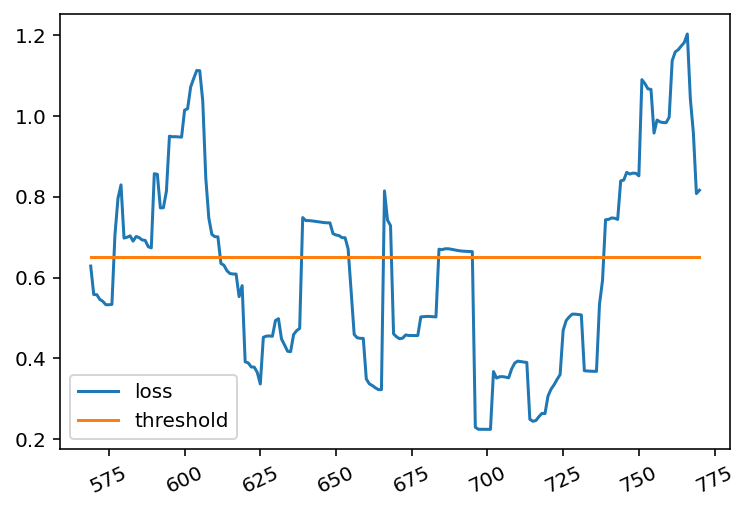

In [58]:
plt.plot(test_score_df.index, test_score_df.loss, label='loss')
plt.plot(test_score_df.index, test_score_df.threshold, label='threshold')
plt.xticks(rotation=25)
plt.legend();

In [59]:
anomalies = test_score_df[test_score_df.anomaly == True]
anomalies.head()

,loss,threshold,anomaly,close
577,0.705266,0.65,True,-2.936358
578,0.795962,0.65,True,-1.189062
579,0.829368,0.65,True,-0.156762
580,0.697771,0.65,True,0.006839
581,0.699823,0.65,True,-1.967134


In [60]:
plt.plot(
  test[TIME_STEPS:].index, 
  scaler.inverse_transform(test[TIME_STEPS:].TemperatureAvg), 
  label='close price'
);

sns.scatterplot(
  anomalies.index,
  scaler.inverse_transform(anomalies.TemperatureAvg),
  color=sns.color_palette()[3],
  s=52,
  label='anomaly'
)
plt.xticks(rotation=25)
plt.legend();

ValueError: ignored